# CSPB 3202 Final Project: Mountain Cart Game

Jordon Young (joyo8856)

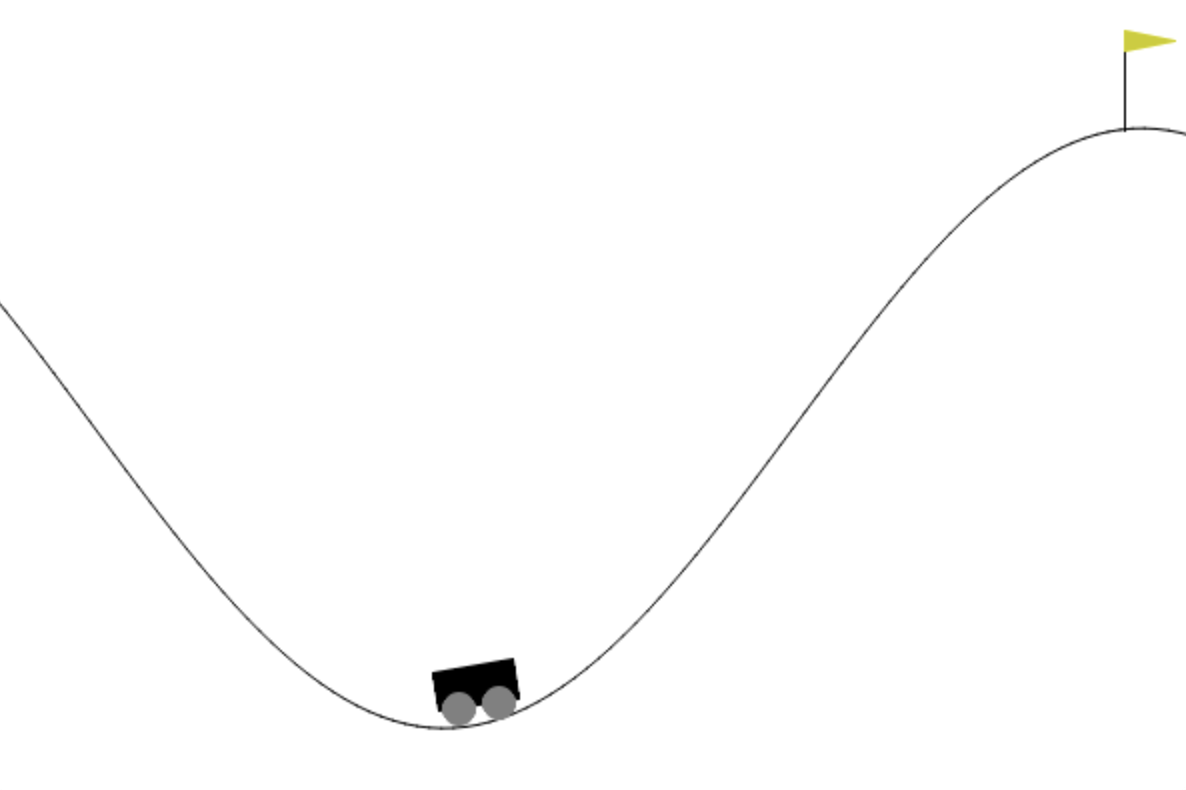

## Project Description

This project is a solution to the [Mountain Car](https://gymnasium.farama.org/environments/classic_control/mountain_car/) game provided by gymnasium. It includes a description of the game rules / environment and two agents: the first is a simple but incredibly effective reflex agent, and the second is a moderately efficient, reliable q-learning trained agent.

## Explanation of Environment

The Mountain Car game is under the Classic Controls category of games which are meant to be simpler than other games, however there are nuances in this game which make it quite tricky.

The rules and rewards are simple: get the car to the flag on the top of the hill to win (and receive a large reward), or incur a small time penalty for each action. The observation (state) available at each step is a tuple containing the position and velocity. The world position is clearly explained in the docs online, but all that is important to know is it's a point on a line--there is only one dimension of position information. The velocity is structured so that negative is to the left and positive is to the right. There is a terminal velocity, but that doesn't hinder anything.

For actions, the cart can chose to do nothing and let gravity do its thing unopposed, or it can chose to apply force to move itself left or right. At this point, a good question is: why can we move directly toward the flag to win? The answer is what makes this little game more complex than it first appears: the car is underpowered (it cannot drive up the hill from a stationary position).

One final note on the environment is that the starting position is stochastic within a range toward the bottom of the valley. This means that there is no certainty which direction the cart is more inclined to move when beginning due to the force of gravity.


In [ ]:
import gymnasium as gym
import math
import numpy as np
import pickle
import random
import time

In [ ]:
game = "MountainCar-v0"

seed = random.randint(0, 100)
step_delay = 0.001

goal_position = 0.5
force = 0.001
gravity = 0.0025
max_speed = 0.07
min_position = -1.2
max_position = 0.6

In [ ]:
TRIALS = []
START_TIME = 0

def initialize_trial_tracking():
    global TRIALS 
    global START_TIME 

    TRIALS = []
    START_TIME = time.time()

def track_trial(passed: bool):
    global TRIALS 
    global START_TIME 

    elapsed_time = time.time() - START_TIME

    TRIALS.append({
        'elapsed_time': elapsed_time,
        'pass': passed
    })

    START_TIME = time.time()

def summarize_trial():
    global TRIALS 

    if TRIALS:
        last_trial = TRIALS[-1]
        print(f"Trial {len(TRIALS)}:\n\tElapsed Time: {last_trial['elapsed_time']:.2f} seconds\n\t{'PASSED' if last_trial['pass'] else 'Failed'}")

def summarize_trials():
    global TRIALS 

    if TRIALS:
        all_elapsed_times = [trial['elapsed_time'] for trial in TRIALS]
        passed_elapsed_times = [trial['elapsed_time'] for trial in TRIALS if trial['pass']]
        pass_count = sum([1 for trial in TRIALS if trial['pass']])
        pass_rate = pass_count / len(TRIALS)

        print(f"Trials: {len(TRIALS)}")
        print(f"Average Time (All) {np.mean(all_elapsed_times):.2f} seconds")
        print(f"Average Time (Passed): {np.mean(passed_elapsed_times):.2f} seconds")
        print(f"Pass Rate: {pass_rate:.2%}")

## A Simple, Yet Remarkably Effective Reflex Agent

Now that you've had a moment to think about the game, it's probably pretty obvious that the cart will need to swing back and forth between the hills until it has enough momentum to reach the mountain top and collect the flag. One way might be to look at the position relative to the geography and decide which direction to move. A simpler idea is to only look at the velocity observation.

This simple reflex agent tries to go with the flow. If the velocity is zero, it chooses a random decision. If the velocity has a non-zero magnitude, it accelerates in the direction of the current velocity. This means that if it's going downhill, it will gain even more speed, and if it's going up hill, it will make more forward progress in that direction than if it had done nothing or tried to slow itself down.

It's simple, but it works because the world is confined and there is no negative penalty for hitting the left wall. If it gains enough speed going up and down the hills, eventually it will reach the goal. If the game were made harder by adding rules such as no touching the left wall or no overshooting the goal, this agent would fail.

This simple agent averages around seven seconds to reach the goal each time with a minimum under six seconds and a maximum over ten seconds. It will always succeed at this game.

[View Demo Link](https://drive.google.com/file/d/1yPxZvWZxF2yU_Brp-90gY1aiJ3LmnR2O)


In [ ]:
def get_action(env, observation):
    _, velocity = observation

    """
    If already moving left, keep moving left
    If already moving right, keep moving right
    """
    if velocity < 0:
        return 0
    elif velocity > 0:
        return 2
    else:
        return env.action_space.sample()
    
def run_reflex(episodes=1000, max_steps=200, render=False):

    env = gym.make(game, render_mode='human' if render else 'rgb_array')
    observation, info = env.reset(seed=seed)
    steps = 0

    initialize_trial_tracking()

    for _ in range(episodes):
        action = get_action(env, observation)
        observation, reward, terminated, truncated, info = env.step(action)
        steps += 1

        if terminated or truncated or steps >= max_steps:
            observation, info = env.reset()
            steps = 0

            passed = False
            if terminated:
                passed = True

            track_trial(passed)

            if render:
                summarize_trial()

        if not render:
            time.sleep(step_delay)

        env.render()

    env.close()
    summarize_trials()

run_reflex(episodes=5000)

In [ ]:
# Uncomment to run the reflex agent in render mode (opens a new window)
# run_reflex(render=True)

# https://drive.google.com/file/d/1yPxZvWZxF2yU_Brp-90gY1aiJ3LmnR2O

"""
Example Output:

Trial 1:
	Elapsed Time: 6.17 seconds
	PASSED
Trial 2:
	Elapsed Time: 7.43 seconds
	PASSED
Trial 3:
	Elapsed Time: 10.62 seconds
	PASSED
Trial 4:
	Elapsed Time: 7.71 seconds
	PASSED
Trial 5:
	Elapsed Time: 5.87 seconds
	PASSED
Trial 6:
	Elapsed Time: 7.37 seconds
	PASSED
Trial 7:
	Elapsed Time: 8.25 seconds
	PASSED
Trial 8:
	Elapsed Time: 5.94 seconds
	PASSED
Trial 9:
	Elapsed Time: 6.56 seconds
	PASSED
Trials: 9
Average Time (All) 7.32 seconds
Average Time (Passed): 7.32 seconds
Pass Rate: 100.00%

"""

### Notes on Other Reflex / Reward Based Models

I did try to create variations of this reflex model and reward based models, but nothing was as effective or simple as the model above. The one model which nearly performed as well has such an overly complicated reward system that it basically predefined the same sort of idea that the cart should try and accelerate as much as it can in the direction it's going. Since modifying the reward system to that level of specificity is not in the sprit of the game, I abandoned those efforts.


## Q-Learning Agent

This q-learning agent is fairly textbook, however it's worth pointing out that it did not work at all until I modified the reward structure. Remember that the environment only comes with a positive reward if the goal is reached and constantly incurs a time penalty. The only information available is the position and the velocity.

Running my q-model with the standard reward did not go well under any tuning of the hyperparameters because the world resists exploration. Especially early on in training where most moves are random, there is no way to build up enough momentum to get to the top of either hill. It was futile.

The solution was to implement my own reward system. I kept with the time penalty per step, then added a very large reward for the goal. The piece that make this model eventually solve the game is that I gave another reward for exploring never before reached positions, with the rewards being stronger nearest the goal. A little incentive and a lot of steps eventually encouraged the agent to find the goal. Once it found the goal, it rather quickly figured out what it needed to do to gether there.

The game comes by default with a max step of 200, which is when the human rendered game will time out. Initially this model was in the 200-500 step range for completing the game which is much, much longer than the reflex model. Some strategies that helped reduce this time included reducing the decay, increasing the time penalty, and increasing the final reward. I played around with the learning rate and settled on a value through trial and error. The final result is a train model that can complete the game under 200 steps, but not quite as fast as the reflex model.

[View Demo Video](https://drive.google.com/file/d/1vV76v2Z98_YcOJ9WJPadrSTNBP7wc8gI/view)


In [ ]:
# Hyperparameters
learning_rate = 0.8
discount_factor = 0.99
epsilon = 1
epsilon_decay = 0.999

# Declare position and velocity spaces
position_space = np.arange(min_position, max_position, 0.01)
velocity_space = np.arange(-max_speed, max_speed, 0.001)

def get_discrete_state(state):
    position, velocity = state

    p_index = np.digitize(position, position_space) - 1
    v_index = np.digitize(velocity, velocity_space) - 1

    return p_index, v_index

"""
Q-Table Helper Functions
"""

q_table = None

def initialize_q_table():
    global q_table
    q_table = np.zeros((len(position_space), len(velocity_space), 3))

def load_q_table():
    global q_table
    with open('q_table.pkl', 'rb') as f:
        q_table = pickle.load(f)

def save_q_table():
    with open('q_table.pkl', 'wb') as f:
        pickle.dump(q_table, f)

In [ ]:
import matplotlib.pyplot as plt

def plot_scores(scores):
    plt.figure(figsize=(10, 5))
    plt.plot(scores, label='Score per Trial')
    plt.xlabel('Trial')
    plt.ylabel('Score')
    plt.title('Scores over Trials')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_epsilon(epsilon_values):
    plt.figure(figsize=(10, 5))
    plt.plot(epsilon_values, label='Epsilon Decay')
    plt.xlabel('Trial')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay over Trials')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_episode_lengths(episode_lengths):
    plt.figure(figsize=(10, 5))
    plt.plot(episode_lengths, label='Episode Length per Trial')
    plt.xlabel('Trial')
    plt.ylabel('Episode Length')
    plt.title('Episode Lengths over Trials')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def run_q_learning(trials=100, episodes=1000, training=True, render=False):
    global q_table
    global epsilon
    global epsilon_decay

    e = epsilon
    e_decay = epsilon_decay
    
    if training:
        initialize_q_table()
    else:
        load_q_table()

    initialize_trial_tracking()

    scores = []
    epsilon_values = []
    episode_lengths = []

    for trial in range(trials):

        env = gym.make(game, render_mode='human' if render else None).env

        state, info = env.reset(seed=seed)
        position, velocity = get_discrete_state(state)

        score = 0
        terminated = False
        truncated = False
        visited_positions = set()
        episode_length = 0

        for episode in range(episodes):
            episode_length += 1

            if training and random.uniform(0, 1) < e:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[position, velocity, :])

            new_state, reward, terminated, truncated, info = env.step(action)
            new_position, new_velocity = get_discrete_state(new_state)

            if terminated: 
                reward = 1000
            elif truncated:
                reward = -1000
            elif new_position not in visited_positions:
                reward = 10 / abs(goal_position - new_position)
                visited_positions.add(new_position)
            else:
                reward = -5
            score += reward

            if training:
                max_future_q = np.max(q_table[new_position, new_velocity, :])
                
                q_value = q_table[position, velocity, action]
                new_q_value = reward + discount_factor * max_future_q
                
                q_table[position, velocity, action] = q_value + learning_rate * (new_q_value - q_value)

            state = new_state
            position = new_position
            velocity = new_velocity

            if render:
                env.render()

            if terminated or truncated:
                break

        scores.append(score)
        epsilon_values.append(e)
        episode_lengths.append(episode_length)
        e *= e_decay

        passed = False
        if terminated or truncated:
            state, info = env.reset()

            if terminated:
                passed = True

            if render:
                summarize_trial()

        track_trial(passed)

        # Print average score for debugging
        print(f"Trial {trial + 1}/{trials}, Score: {score}, Epsilon: {e}, Episode Length: {episode_length}")

    env.close()
    summarize_trials()

    if training:
        save_q_table()

    # Plot the results
    plot_scores(scores)
    plot_epsilon(epsilon_values)
    plot_episode_lengths(episode_lengths)

run_q_learning(trials=4000, episodes=3000, training=True, render=False)

In [ ]:
"""
Example Output:

...
Trial 3990/4000, Score: 597.9447758416052, Epsilon: 0.0184628194063454, Episode Length: 226
Trial 3991/4000, Score: 619.1570726290738, Epsilon: 0.018444356586939055, Episode Length: 226
Trial 3992/4000, Score: 617.5163121693431, Epsilon: 0.018425912230352115, Episode Length: 222
Trial 3993/4000, Score: 577.908165204109, Epsilon: 0.018407486318121762, Episode Length: 225
Trial 3994/4000, Score: 614.9183909643928, Epsilon: 0.01838907883180364, Episode Length: 221
Trial 3995/4000, Score: 582.1068550178267, Epsilon: 0.018370689752971837, Episode Length: 223
Trial 3996/4000, Score: 579.3342792281271, Epsilon: 0.018352319063218867, Episode Length: 223
Trial 3997/4000, Score: 599.227138421145, Epsilon: 0.018333966744155647, Episode Length: 219
Trial 3998/4000, Score: 599.837723964836, Epsilon: 0.01831563277741149, Episode Length: 226
Trial 3999/4000, Score: 591.3593029039071, Epsilon: 0.01829731714463408, Episode Length: 223
Trial 4000/4000, Score: 606.7971656676789, Epsilon: 0.018279019827489446, Episode Length: 220
Trials: 4000
Average Time (All) 0.01 seconds
Average Time (Passed): 0.01 seconds
Pass Rate: 95.65%
"""

In [ ]:
# Uncomment to see the Q-Learning agent after having trained it
run_q_learning(trials=10, episodes=200, training=False, render=True)

# https://drive.google.com/file/d/1vV76v2Z98_YcOJ9WJPadrSTNBP7wc8gI/view

"""
Example Output:

Trial 1/10, Score: 831.3182897582121, Epsilon: 0.999, Episode Length: 127
Trial 1:
	Elapsed Time: 8.70 seconds
	PASSED
Trial 2/10, Score: 831.3182897582121, Epsilon: 0.998001, Episode Length: 127
Trial 2:
	Elapsed Time: 8.71 seconds
	PASSED
Trial 3/10, Score: 831.3182897582121, Epsilon: 0.997002999, Episode Length: 127
Trial 3:
	Elapsed Time: 8.70 seconds
	PASSED
Trial 4/10, Score: 831.3182897582121, Epsilon: 0.996005996001, Episode Length: 127
Trial 4:
	Elapsed Time: 8.71 seconds
	PASSED
Trial 5/10, Score: 831.3182897582121, Epsilon: 0.995009990004999, Episode Length: 127
Trial 5:
	Elapsed Time: 8.70 seconds
	PASSED
Trial 6/10, Score: 831.3182897582121, Epsilon: 0.994014980014994, Episode Length: 127
Trial 6:
	Elapsed Time: 8.70 seconds
	PASSED
Trial 7/10, Score: 831.3182897582121, Epsilon: 0.993020965034979, Episode Length: 127
Trial 7:
	Elapsed Time: 8.69 seconds
	PASSED
Trial 8/10, Score: 831.3182897582121, Epsilon: 0.9920279440699441, Episode Length: 127
Trial 8:
	Elapsed Time: 8.69 seconds
	PASSED
Trial 9/10, Score: 831.3182897582121, Epsilon: 0.9910359161258742, Episode Length: 127
Trial 9:
	Elapsed Time: 8.70 seconds
	PASSED
Trial 10/10, Score: 831.3182897582121, Epsilon: 0.9900448802097482, Episode Length: 127
Trials: 10
Average Time (All) 8.70 seconds
Average Time (Passed): 8.70 seconds
Pass Rate: 100.00%

"""

### Training Graphics


![image.png](./scores-per-trial.png)

Initially there is a long period of poor performance as there is more exploration than exploitation. There are early successes, but are infrequent. As the trials progress, the scores begin to increase. The first major increases in scores come from hitting the final goal, but toward the tail end the increases come from reducing the time penalty.


![image.png](./epsilon-decay.png)

It was very tricky to get the steps, epochs, and epsilon decay to work well. This graph looks about perfect to me in that it is a fairly sharp decline early on then tappers off, but it's not too sharp. There is still plenty or random exploration to find new paths and to refine. When the epsilon bottomed out to early, the model did not continue to get better with more epochs. With this configuration, it hits near zero right as training finishes which helps to make the agent perform more predictably.


![image.png](./episode-length.png)

The episode length is set to a maximum of 3000 steps. As the model learns and begins to reach the goal, the steps get shorter and shorter. Early on, there is a lot of randomness and hasn't been much learning so the line is erratic. Toward the middle, it starts to stabilize with occasional lower than expected times, then toward the end it stabilizes lower with occasional less performant trials due the the randomness of the cart spawn.


## Conclusion

While it appears to be simple, the Mountain Car game has some subtle traps that require additional strategies to solve. The reflex agent was simple but was unbeatable by any other strategy I could attempt.

The q-learning algorithm with bonus rewards for newly visited locations was a valid solution to the problem. It was reliable and took a little over a second to complete on average compared to the reflex model.

One shortfall of my model is that it is not planning. It is only looking at immediate next steps. A future area to investigate would be algorithms that can look more than one frame into the future. While I do think the q-learning model did a fair job identifying that consistency (applying force in the direction already moving) is a good idea, it doesn't appear from the demo to have ever figured out that it doesn't need to go all the way up the right hill or can make it up the right hill with only moderate momentum. If you compare the demo videos, one of the reasons the reflex is quicker on average is that it keeps going as far as it can, including up the right hill even if it's just barely making it to the top. Being able to plan for minimum necessary force required would reduce the completion time.

Another fun exercise would be changing the game rules to add penalties to bumping into the left wall or overshooting the goal. The minor tweaks would render my reflex agent useless.
